# Estimating Wind Fetch

Anna Petrasova  
2025-09-09

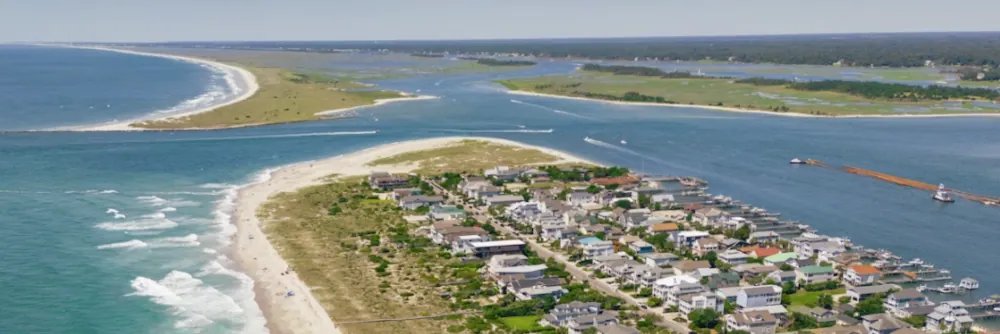

# Introduction

Wind fetch — the distance wind blows across open water — is a key factor
in wave generation and shoreline exposure. It is widely used in coastal
engineering to estimate wave height, and in ecology to assess habitat
vulnerability to wave energy. This tutorial demonstrates how to use the
[r.windfetch](https://grass.osgeo.org/grass-devel/manuals/r.windfetch.html)
addon in GRASS to compute fetch lengths for a case study on the North
Carolina coast.

We will:

-   Set up a GRASS project for North Carolina.
-   Import elevation data to derive land and water areas.
-   Download a wind rose.
-   Estimate a weighted wind fetch for a selected point on the coast.
-   Derive weighted wind fetch for part of the coastline.
-   Visualize the results.

This approach demonstrates how to leverage new Python API features
introduced in GRASS 8.5—specifically, the [Tools
API](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.tools.html#)
and the
[RegionManager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.RegionManager)
context manager.

> **How to run this tutorial?**
>
> This tutorial is prepared to be run in a Jupyter notebook locally or
> using services such as Google Colab. You can [download the notebook
> here](windfetch.ipynb).
>
> If you are not sure how to get started with GRASS, checkout the
> tutorials [Get started with GRASS & Python in Jupyter
> Notebooks](../get_started/fast_track_grass_and_python.qmd) and [Get
> started with GRASS in Google
> Colab](../get_started/grass_gis_in_google_colab.qmd).

# Setup

Start with importing Python packages. To import the *grass* package, you
need to tell Python where the GRASS Python package is (can be skipped
for some environments).

In [1]:
# import standard Python packages
import os
import sys
import subprocess
from pathlib import Path

# check where GRASS python packages are and add them to PATH
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# import GRASS python packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

We will switch our working directory to a directory with enough space,
this is where we will download the datasets and create our GRASS
project.

    os.chdir("path/to/data")

Now create a GRASS project called *windfetch* with a Coordinate
Reference System (CRS) used in North Carolina ([EPSG
32119](https://spatialreference.org/ref/epsg/32119/)). We create a new
GRASS project for the tutorial. The EPSG code 32119 corresponds to NAD83
/ North Carolina, a suitable projection for working in this region. Then
we initialize the GRASS session in Jupyter, pointing it to the newly
created project. This sets up the working environment.

In [2]:
gs.create_project("windfetch", epsg="32119")
gj.init("windfetch")

## Study area

We download a shapefile of US state boundaries from the [U.S. Census
Bureau TIGER/Line
dataset]((https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)).
This gives us a polygon map of all states, from which we can extract
North Carolina. This data will help us define our study area.

In [3]:
import urllib.request
import zipfile
from pathlib import Path

url = "https://www2.census.gov/geo/tiger/GENZ2024/shp/cb_2024_us_state_20m.zip"
states_filename, headers = urllib.request.urlretrieve(url)
with zipfile.ZipFile(states_filename, "r") as zip_ref:
    zip_ref.extractall()
os.remove(states_filename)
states_filename = Path(url).with_suffix(".shp").name

We create a Tools object that lets us call GRASS tools as Python
functions (e.g., tools.v_import instead of running v.import at the
command line).

In [4]:
tools = Tools()
tools.v_import(input=states_filename, output="states")

> **Running GRASS 8.4?**
>
> This tutorial uses new API available since GRASS 8.5. If you are
> running GRASS 8.4, you can use the [shell-like tool calling
> API](https://grass.osgeo.org/grass-devel/manuals/python_intro.html#shell-like-tool-calling)
> instead. So instead of
> `tools.v_import(input=states_filename, output="states")`, you can use
> `gs.run_command("v.import", input=states_filename, output="states")`.

We query the attribute table of the states map and display it as a
Pandas DataFrame. This lets us inspect column and state names.

In [5]:
import pandas as pd

pd.DataFrame(tools.v_db_select(map="states", format="json")["records"])

<figure>
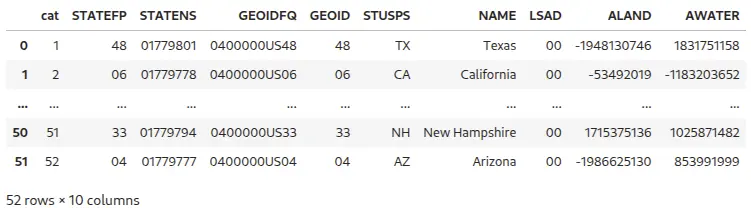
<figcaption aria-hidden="true">US states DataFrame</figcaption>
</figure>

We extract North Carolina boundaries into a new vector map *NC* and
display the North Carolina polygon in an interactive map widget,
verifying that the state boundary was exported correctly.

In [6]:
tools.v_extract(input="states", output="NC", where="name == 'North Carolina'")

NC_map = gj.InteractiveMap()
NC_map.add_vector("NC")
NC_map.show()

Providing you have [ipyleaflet](https://ipyleaflet.readthedocs.io/)
installed, you can interactively set the extent of the computational
region, selecting area around Core Sound, part of the Outer Banks of
North Carolina. You need to select sufficiently large area to allow for
the correct fetch computation. You can also set the region directly:

In [7]:
tools.g_region(n=152610, s=94020, w=811200, e=876330)

<figure>
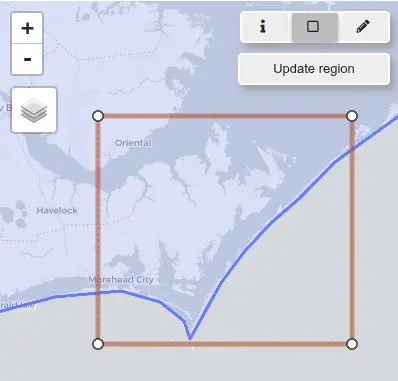
<figcaption aria-hidden="true">Setting computational region
interactively</figcaption>
</figure>

## Elevation data

One of the important inputs to r.windfetch is a binary raster
representing land (1) and water (0). If the land polygons are not
readily available, or they are not detailed enough, this raster can be
easily derived from an elevation raster.

We install the
[r.in.usgs](https://grass.osgeo.org/grass-devel/manuals/addons/r.in.usgs.html)
addon, which provides convenient access to elevation data (USGS
NED/3DEP) directly from within GRASS.

In [8]:
tools.g_extension(extension="r.in.usgs")

This addon will download elevation data based on the extent of the
current computational region. The resolution of the imported dataset is
set automatically based on the type of elevation product. In our case we
will use the 1 arc-second NED product corresponding to approximately 30
meters.

We run r.in.usgs with the -i flag to list available elevation datasets
(here, the NED product). This lets us see what tiles are available for
our region (the output may be different in the future as the data is
updated by USGS).

In [9]:
print(tools.r_in_usgs(flags="i", product="ned", ned_dataset="ned1sec").text)

``` text
USGS file(s) to download:
-------------------------
Total download size:    58.40 MB
Tile count: 4
USGS SRS:   wgs84
USGS tile titles:
USGS 1 Arc Second n35w077 20250507
USGS 1 Arc Second n36w077 20250507
USGS 1 arc-second n35w077 1 x 1 degree
USGS 1 arc-second n36w077 1 x 1 degree
-------------------------
```

We remove the flag and rerun r.in.usgs to actually download and import
the data. We filter the data to only include the tiles with “degree” in
the title name.

In [10]:
tools.r_in_usgs(
    product="ned",
    output_name="ned",
    ned_dataset="ned1sec",
    title_filter="degree",
    nprocs=2,
)

Let’s look at the data we just downloaded. We will display only
elevation values larger than 0:

In [11]:
ned_map = gj.Map()
ned_map.d_background(color="aqua")
ned_map.d_rast(map="ned", values="0.0001-100")
ned_map.show()

<figure>
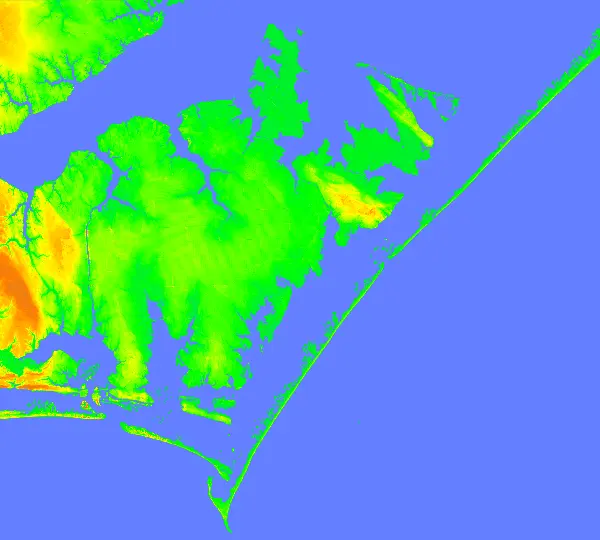
<figcaption aria-hidden="true">Elevation data</figcaption>
</figure>

Set computational region to match the extent and resolution of the NED
dataset.

In [12]:
tools.g_region(raster="ned")

We derive the land/water raster using raster algebra with
[r.mapcalc](https://grass.osgeo.org/grass-devel/manuals/r.mapcalc.html).
Values above sea level are set to 1 (land), while sea level and below
are 0 (water). This prepares the key input raster for r.windfetch.

In [13]:
tools.r_mapcalc(expression="land = if(ned > 0, 1, 0)")

ned_map = gj.Map()
ned_map.d_rast(map="land")
ned_map.show()

<figure>
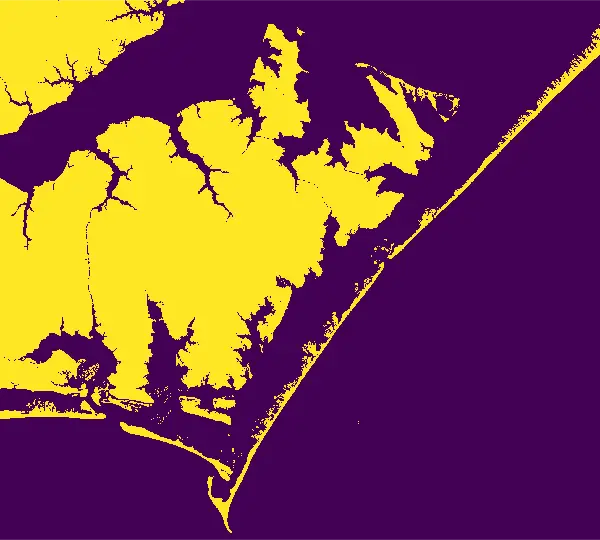
<figcaption aria-hidden="true">Land/water raster</figcaption>
</figure>

## Wind data

Wind roses show the frequency of winds from different directions, and at
different speeds, over a given period of time ([NC Air Quality
Portal](https://airquality.climate.ncsu.edu/wind/)). We will use this
information to compute wind fetch weighted by the percentage of wind
observed from the different directions.

We will use wind rose dataset (CSV) for station KMRH (Beaufort, NC) that
is near our study area. The file can be downloaded
[here](windrose_KMRH_2001-07-05_2025-09-01.csv) or accessed from [NC Air
Quality Portal](https://airquality.climate.ncsu.edu/wind/).

<figure>
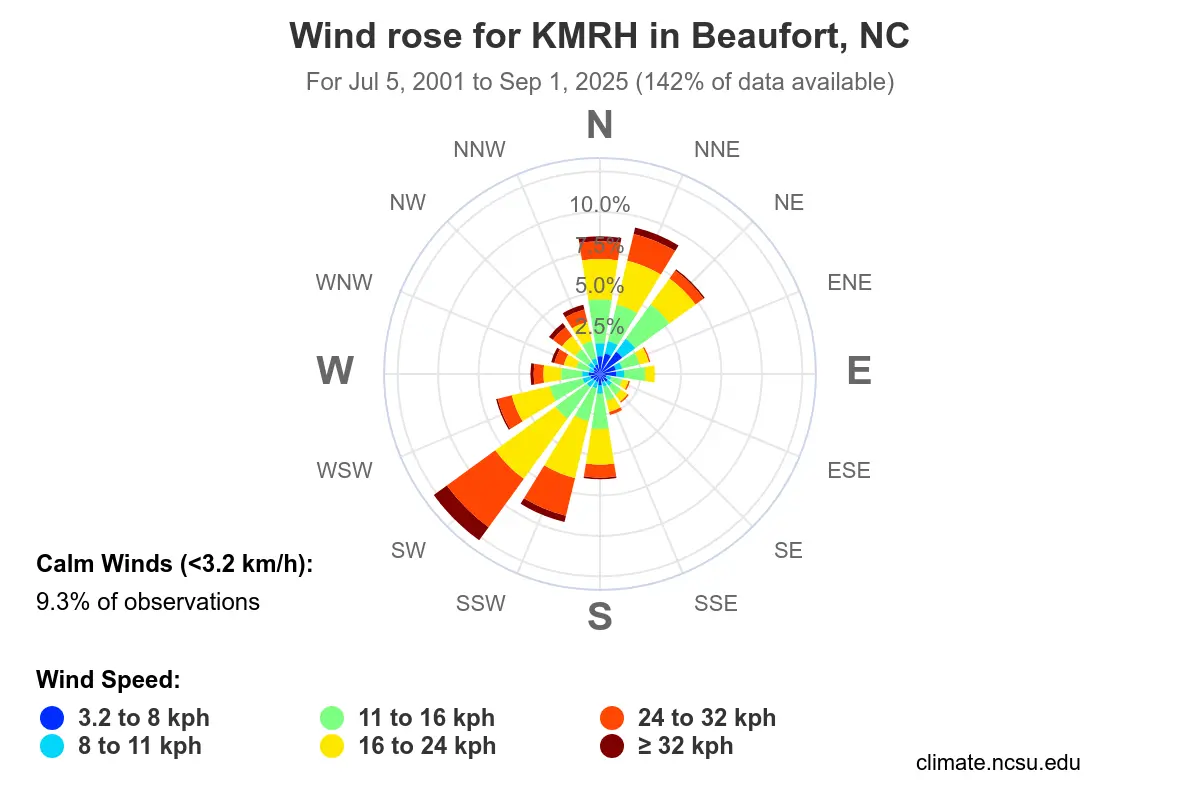
<figcaption aria-hidden="true">Wind rose for Beaufort, NC</figcaption>
</figure>

First, read the CSV file into a Pandas DataFrame.

In [14]:
wind_df = pd.read_csv("windrose_KMRH_2001-07-05_2025-09-01.csv")
wind_df

We calculate the total frequency of winds per direction sector by
summing across the available columns. This gives us the relative
importance of each direction.

In [15]:
wind_df["total"] = wind_df.sum(axis=1, numeric_only=True)

We add a directions column, assigning compass angles to each wind
sector. Here, each sector is 22.5° apart (16 sectors total). We round
the angles to integers to match the integer directions used by
r.windfetch.

We also convert wind directions from the meteorological “from”
convention to the “to” convention by adding 180°, so they align with
fetch measurements pointing toward open water.

In [16]:
wind_df["directions"] = [round(i * 22.5) for i in range(len(wind_df))]
wind_df["directions"] = (wind_df["directions"] + 180) % 360
wind_df

<figure>
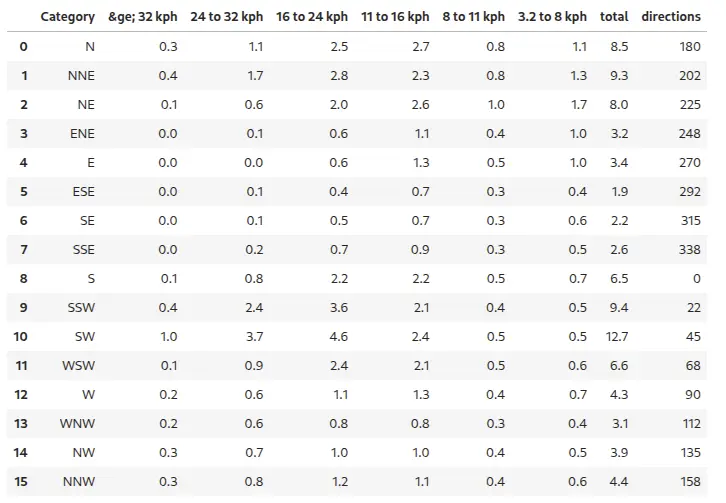
<figcaption aria-hidden="true">Wind DataFrame</figcaption>
</figure>

# Wind fetch analysis for a single point

We install r.windfetch addon, which computes wind fetch distances over
water for given input points and directions.

In [17]:
tools.g_extension(extension="r.windfetch")

We will select a point interactively and export to a vector map *point*.
Make sure the point is located somewhere along the coast on water, not
land. This point will serve as a location to compute wind fetch in
different directions.

In [18]:
ned_map = gj.InteractiveMap()
ned_map.add_raster("land")
ned_map.show()

<figure>
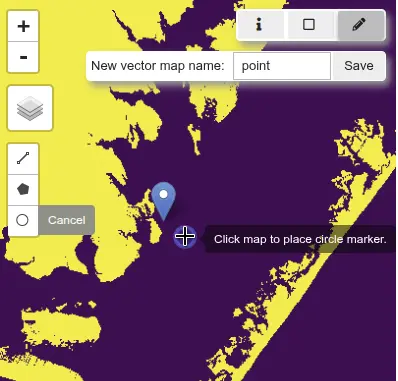
<figcaption aria-hidden="true">Interactive point selection</figcaption>
</figure>

Alternatively create a vector point with:

In [19]:
import io

tools.v_in_ascii(input=io.StringIO("838658,112214"), output="point", separator="comma")

The *effective fetch* is computed by averaging multiple radials spread
around the main wind direction. In r.windfetch, this is controlled by
two parameters:

-   **minor_directions** – total number of radials used to compute
    effective fetch (including the central/main radial).
-   **minor_step** – angular spacing between adjacent radials (in
    degrees).

Common configurations (based on U.S. Army Corps of Engineers Shore
Protection Manual):

| Method             | minor_directions | minor_step | arc width |
|--------------------|-----------------:|-----------:|----------:|
| **SPM**            |                9 |         3° |       24° |
| **SPM-restricted** |                5 |         3° |       12° |
| **Single radial**  |                1 |          – |        0° |

The broader arc (SPM) generally better reflects real-world spreading of
wave energy, while the narrower arc (SPM-restricted) can be more
appropriate in environments with long, narrow fetches such as estuaries
or channels.

<figure>
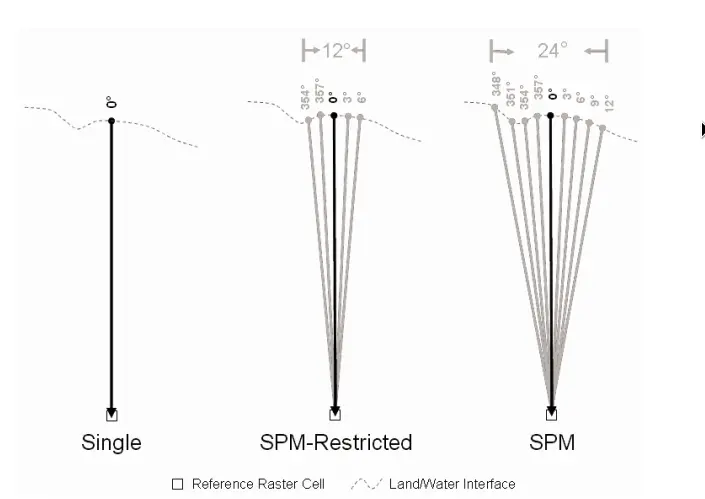
<figcaption aria-hidden="true">Wind fetch methods (Rohweder et
al. 2012)</figcaption>
</figure>

We run r.windfetch from the selected point with the SPM configuration.
The output is returned as JSON, which we capture in a Python dictionary.
Flag *c* tells r.windfetch to use compass directions (clockwise from
North).

In [20]:
point_fetch = tools.r_windfetch(
    input="land",
    points="point",
    format="json",
    step=1,
    minor_directions=9,
    minor_step=3,
    flags="c",
)[0]

We convert the r.windfetch output into a Pandas DataFrame for easier
inspection. Each row corresponds to a direction and its computed fetch
length (in meters).

In [21]:
fetch_df = pd.DataFrame(
    {"directions": point_fetch["directions"], "fetch": point_fetch["fetch"]}
)
fetch_df

We create a polar plot (rose diagram) of fetch lengths. This
visualization shows, for the selected point, how far wind can blow
unobstructed in different directions. Image below shows a rose diagram
for the SPM and SPM-restricted configurations.

In [22]:
import matplotlib.pyplot as plt
import numpy as np

directions = np.deg2rad(point_fetch["directions"])
ax = plt.subplot(111, polar=True)
ax.plot(directions, point_fetch["fetch"], marker="o", linestyle="-")
ax.fill(directions, point_fetch["fetch"], alpha=0.3)
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_title("Wind fetch", va="bottom")
plt.show()

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure>
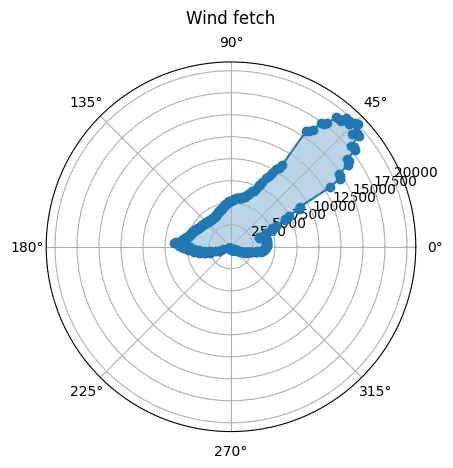
<figcaption aria-hidden="true">SPM</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure>
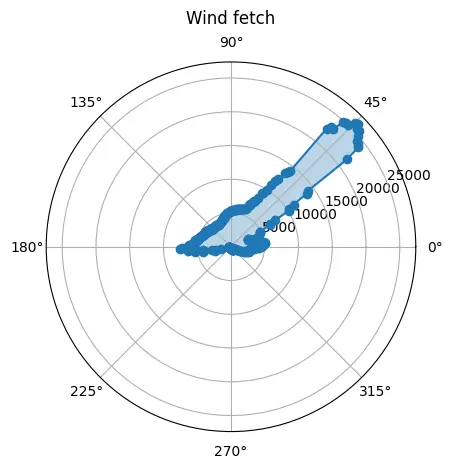
<figcaption aria-hidden="true">SPM-restricted</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

We join the wind rose data with the fetch results by matching
directions. This allows us to combine how often wind blows from a
direction with how far it can travel.

In [23]:
merged_df = pd.merge(wind_df, fetch_df, on="directions", how="inner")

We compute weighted fetch: multiplying fetch length by wind frequency
(percentage). This creates an effective measure of wave-generating
potential.

In [24]:
merged_df["weighted_fetch"] = merged_df["fetch"] * merged_df["total"] / 100

We calculate the overall effective fetch for the point by summing across
all wind directions. This produces a single index summarizing wave
exposure, integrating both shoreline geometry and real wind climate.

In [25]:
merged_df["weighted_fetch"].sum()

At this point, the tutorial has shown a full workflow: preparing data,
running r.windfetch, and combining with wind rose data.

# Wind fetch for points along a coastline

Now we will create vector point map with points along a coastline. We
will select only part of the coastline, focusing on a section of
Carteret county, North Carolina, within our study area. Specifically we
will select a single census tract.

Download NC tract boundaries:

In [26]:
url = "https://www2.census.gov/geo/tiger/TIGER2024/TRACT/tl_2024_37_tract.zip"
tracts_filename, headers = urllib.request.urlretrieve(url)
with zipfile.ZipFile(tracts_filename, "r") as zip_ref:
    zip_ref.extractall()
os.remove(tracts_filename)
tracts_filename = Path(url).with_suffix(".shp").name

We will import only tracts that fall in our study area (i.e. within our
current computational region extent).

In [27]:
tools.v_import(input=tracts_filename, output="tracts", extent="region")

Display the tracts, select one and and find its GEOID:

In [28]:
point_map = gj.InteractiveMap()
point_map.add_vector("tracts")
point_map.show()

<figure>
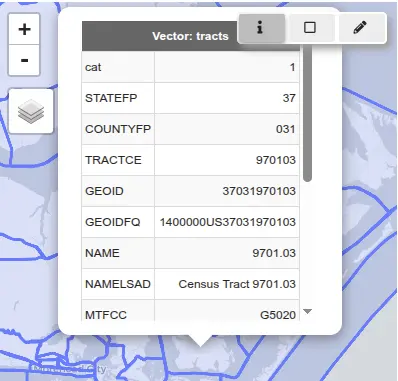
<figcaption aria-hidden="true">Query map of tracts</figcaption>
</figure>

Extract the tract:

In [29]:
tools.v_extract(input="tracts", output="tract", where="GEOID = 37031970103")

We will create a vector map of points along the coastline by first
growing a single-cell buffer along the coast. This ensures the points
fall on water. The buffer cells are then vectorized into points. The
[r.buffer](https://grass.osgeo.org/grass-devel/manuals/r.buffer.html)
tool creates cells with value 1 (original land) and value 2 (buffer). We
set cells with value 1 to null, leaving only the coastal points.

We use a
[RegionManager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.RegionManager)
context manager to temporarily set the computational region extent to
the tract vector and aligning the raster grid to the land map. This
ensures that the buffer is computed only within the tract extent but the
fetch analysis will be using land data on the full study area.

In [30]:
with gs.RegionManager(vector="tract", align="land"):
    tools.r_buffer(flags="z", input="land", output="buffer", distances=30)
    tools.r_null(map="buffer", setnull=1)
    tools.r_to_vect(flags="t", input="buffer", output="points", type="point")

Next, we compute the wind fetch for each point in the vector map using
the SPM setting.

In [31]:
points_fetch = tools.r_windfetch(
    input="land",
    points="points",
    format="json",
    step=1,
    minor_directions=9,
    minor_step=3,
    flags="c",
)

Similarly to the previous example, we will load fetch data into a Pandas
DataFrame. Since we are getting a list (fetch data for each point), we
will use the
[explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html)
function to transform the list into a DataFrame.

In [32]:
fetch_df = pd.DataFrame(points_fetch)
fetch_df = fetch_df.explode(["directions", "fetch"], ignore_index=True)
fetch_df = fetch_df.rename(columns={"directions": "directions"})

We will join the wind rose data with the fetch results by matching
directions.

In [33]:
merged_df = pd.merge(wind_df, fetch_df, on="directions", how="inner")
merged_df["weighted_fetch"] = merged_df["fetch"] * merged_df["total"] / 100
merged_df

We can now calculate the overall effective fetch for each point by
summing across all wind directions.

In [34]:
merged_df = merged_df.groupby(["x", "y"], as_index=False)["weighted_fetch"].sum()

## Visualization

Final step is visualizing the data in a web map.

We will convert the DataFrame to GeoJSON in EPSG:4326. First, we will
create a CSV text file from the DataFrame and convert it into a GRASS
vector map. Then, we will convert the vector map to GeoJSON, ensuring
the CRS is set to EPSG:4326 (ensured by specifying the RFC7946
standard).

In [35]:
merged_df.to_csv("results.txt", index=False)
tools.v_in_ascii(
    input="results.txt",
    output="results",
    separator="comma",
    columns="x double, y double, fetch double",
    skip=1,
)
tools.v_out_ogr(
    input="results", output="results.json", format="GeoJSON", lco="RFC7946=YES"
)

We will use [folium](https://python-visualization.github.io/folium/) to
create an interactive map. The darker colors represent higher fetch
values.

In [36]:
import geopandas as gpd
import folium
import branca.colormap as cm

# Load GeoJSON
gdf = gpd.read_file("results.json")

values = gdf["fetch"]
colormap = cm.linear.YlGnBu_07.scale(values.min(), values.max())
colormap.caption = "Weighted Fetch"

# Center map at the mean location
m = folium.Map(
    location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()],
    zoom_start=12,
    tiles="CartoDB positron",
)

# Add points
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=5,
        weight=0,
        fill=True,
        fill_color=colormap(row["fetch"]),
        fill_opacity=0.7,
        tooltip=f"Weighted Fetch: {row['fetch']:.2f}"
    ).add_to(m)

# Add colormap legend
colormap.add_to(m)
m

<figure>
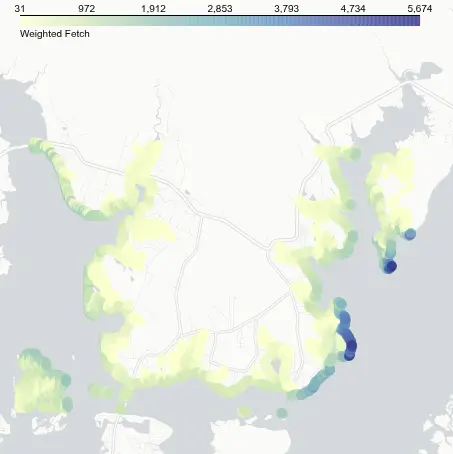
<figcaption aria-hidden="true">Final weighted wind fetch
map</figcaption>
</figure>

Note that estuaries have much lower fetch values, while the highest
fetch occurs along the east coast of Bells and Davis Islands, driven by
the northeast orientation of Core Sound and the prevailing winds.

# References

-   Rohweder, J., Rogala, J. T., Johnson, B. L., Anderson, D., Clark,
    S., Chamberlin, F., Potter, D., and Runyon, K., 2012, [Application
    of Wind Fetch and Wave Models for Habitat Rehabilitation and
    Enhancement Projects – 2012
    Update](https://www.umesc.usgs.gov/management/dss/wind_fetch_wave/wind_fetch_wave_2012update/wind_wave_2012_update_070814.pdf).
    Contract report prepared for U.S. Army Corps of Engineers’ Upper
    Mississippi River Restoration – Environmental Management Program. 52
    p.

# Acknowledgements

The development of this tutorial was supported by NSF Award #2322073,
granted to Natrx, Inc.

NC coastline photo by [Samuel
Cruz](https://unsplash.com/@samuelcruz?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash)
on
[Unsplash](https://unsplash.com/photos/a-beach-with-houses-and-water-danWxMtwW_g?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash).